In [1]:
import numpy as np # linear algebra
import pandas as pd
import seaborn as sns
import nltk
import re
import os
from pprint import pprint

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics.pairwise import cosine_similarity

from nltk.corpus import stopwords, words as english_words

import openai
openai.api_key = os.environ["OPENAI_API_KEY"]



In [2]:
nltk.download("stopwords")
nltk.download("words")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\AdamScarlat\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\AdamScarlat\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\words.zip.


True

In [3]:
legal_docs = pd.read_csv("./data/legal_text_classification.csv")
legal_docs.head()

,case_id,case_outcome,case_title,case_text
0,Case1,cited,Alpine Hardwood (Aust) Pty Ltd v Hardys Pty Lt...,Ordinarily that discretion will be exercised s...
1,Case2,cited,Black v Lipovac [1998] FCA 699 ; (1998) 217 AL...,The general principles governing the exercise ...
2,Case3,cited,Colgate Palmolive Co v Cussons Pty Ltd (1993) ...,Ordinarily that discretion will be exercised s...
3,Case4,cited,Dais Studio Pty Ltd v Bullett Creative Pty Ltd...,The general principles governing the exercise ...
4,Case5,cited,Dr Martens Australia Pty Ltd v Figgins Holding...,The preceding general principles inform the ex...


In [4]:
pprint (legal_docs.iloc[100]["case_text"])

('Gedeon v Commissioner of New South Wales Crime Commission [2008] HCA 43 ; '
 '(2008) 82 ALJR 1465 at [43] the High Court said: The expression '
 '"jurisdictional fact" was used somewhat loosely in the course of '
 'submissions. Generally the expression is used to identify a criterion the '
 'satisfaction of which enlivens the exercise of the statutory power or '
 'discretion in question. If the criterion be not satisfied then the decision '
 'purportedly made in exercise of the power or discretion will have been made '
 'without the necessary statutory authority required of the decision maker.')


In [5]:
print (legal_docs.info())
legal_docs.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24985 entries, 0 to 24984
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   case_id       24985 non-null  object
 1   case_outcome  24985 non-null  object
 2   case_title    24985 non-null  object
 3   case_text     24809 non-null  object
dtypes: object(4)
memory usage: 780.9+ KB
None


case_id           0
case_outcome      0
case_title        0
case_text       176
dtype: int64

In [6]:
# impute missing text with title
legal_docs["case_text"] = np.where(legal_docs["case_text"].isna(), legal_docs["case_title"], legal_docs["case_text"])

In [7]:
legal_docs.isna().sum()

case_id         0
case_outcome    0
case_title      0
case_text       0
dtype: int64

In [8]:
def clean_text_column(df, text_column_name):
    # Define a set of English stopwords
    stop_words = set(stopwords.words("english"))

    # Define a set of valid English words
    english_words_set = set(english_words.words())

    # Helper function to clean a single text string
    def clean_text(text):
        # Remove non-alphabetic characters and convert to lowercase
        text = re.sub(r"[^a-zA-Z]", " ", text).lower()

        # Tokenize the text into words
        words = text.split()

        # Remove stopwords, single-letter words, and non-English words
        words = [word for word in words if word not in stop_words and len(word) > 1 and word in english_words_set]

        # Join the cleaned words back into a string
        cleaned_text = " ".join(words)

        return cleaned_text
    
    clean_column_name = f"{text_column_name}_clean"
    # Apply the clean_text function to the specified column
    df[clean_column_name] = df[text_column_name].apply(clean_text)

    return df


clean_text_column(legal_docs, 'case_text')


,case_id,case_outcome,case_title,case_text,case_text_clean
0,Case1,cited,Alpine Hardwood (Aust) Pty Ltd v Hardys Pty Lt...,Ordinarily that discretion will be exercised s...,ordinarily discretion follow event party party...
1,Case2,cited,Black v Lipovac [1998] FCA 699 ; (1998) 217 AL...,The general principles governing the exercise ...,general governing exercise discretion award in...
2,Case3,cited,Colgate Palmolive Co v Cussons Pty Ltd (1993) ...,Ordinarily that discretion will be exercised s...,ordinarily discretion follow event party party...
3,Case4,cited,Dais Studio Pty Ltd v Bullett Creative Pty Ltd...,The general principles governing the exercise ...,general governing exercise discretion award in...
4,Case5,cited,Dr Martens Australia Pty Ltd v Figgins Holding...,The preceding general principles inform the ex...,preceding general inform exercise discretion d...
...,...,...,...,...,...
24980,Case25203,cited,Reches Pty Ltd v Tadiran Pty Ltd (1998) 85 FCR...,That is not confined to persons who control th...,confined control company benefit succeed unrep...
24981,Case25204,cited,Sir Lindsay Parkinson &amp; Co Ltd v Triplan L...,Once the threshold prescribed by s 1335 is sat...,threshold satisfied discretion whether order s...
24982,Case25205,cited,Spiel v Commodity Brokers Australia Pty Ltd (I...,Once the threshold prescribed by s 1335 is sat...,threshold satisfied discretion whether order s...
24983,Case25206,distinguished,"Tullock Ltd v Walker (Unreported, Supreme Cour...",Given the extent to which Deumer stands to gai...,given extent gain successful cause action appa...


In [153]:

tfidf = TfidfVectorizer(max_df=0.9, min_df=2, max_features=10000, stop_words='english', token_pattern=r'(?u)\b[A-Za-z]+\b')
dtm = tfidf.fit_transform(legal_docs['case_text_clean'])

dtm.shape

(24985, 10000)

In [154]:
LDA = LatentDirichletAllocation(n_components=5, random_state=101)
LDA.fit(dtm)

LatentDirichletAllocation(n_components=5, random_state=101)

In [155]:
LDA.components_.shape

(5, 10000)

In [156]:
topic_results = LDA.transform(dtm)

# Now we will check the shape
topic_results.shape

(24985, 5)

In [157]:
topic_results[0]

array([0.83431592, 0.04138432, 0.04147253, 0.04134339, 0.04148383])

In [158]:
legal_docs['Topic'] = topic_results.argmax(axis=1)
legal_docs.head(10)

,case_id,case_outcome,case_title,case_text,case_text_clean,Topic
0,Case1,cited,Alpine Hardwood (Aust) Pty Ltd v Hardys Pty Lt...,Ordinarily that discretion will be exercised s...,ordinarily discretion follow event party party...,0
1,Case2,cited,Black v Lipovac [1998] FCA 699 ; (1998) 217 AL...,The general principles governing the exercise ...,general governing exercise discretion award in...,0
2,Case3,cited,Colgate Palmolive Co v Cussons Pty Ltd (1993) ...,Ordinarily that discretion will be exercised s...,ordinarily discretion follow event party party...,0
3,Case4,cited,Dais Studio Pty Ltd v Bullett Creative Pty Ltd...,The general principles governing the exercise ...,general governing exercise discretion award in...,0
4,Case5,cited,Dr Martens Australia Pty Ltd v Figgins Holding...,The preceding general principles inform the ex...,preceding general inform exercise discretion d...,0
5,Case6,cited,GEC Marconi Systems Pty Ltd v BHP Information ...,I accept that the making of a rolled up offer ...,accept making rolled offer inclusive interest ...,0
6,Case7,cited,John S Hayes &amp; Associates Pty Ltd v Kimber...,The preceding general principles inform the ex...,preceding general inform exercise discretion d...,0
7,Case8,cited,Seven Network Limited v News Limited (2007) 24...,On the question of the level of unreasonablene...,question level unreasonableness necessary attr...,4
8,Case9,applied,Australian Broadcasting Corporation v O'Neill ...,recent decision of the High Court in Australia...,recent decision high court corporation issue v...,2
9,Case10,followed,Hexal Australia Pty Ltd v Roche Therapeutics I...,Hexal Australia Pty Ltd v Roche Therapeutics I...,therapeutics likelihood irreparable harm stone...,4


In [159]:
tfidf.get_feature_names_out()

array(['aa', 'aba', 'abalone', ..., 'zero', 'zinc', 'zone'], dtype=object)

In [160]:
n_words = 4

for index, topic in enumerate(LDA.components_):
    print(f"THE TOP {n_words} WORDS FOR TOPIC #{index}")
    list_keywords = [tfidf.get_feature_names_out()[index] for index in topic.argsort()[-n_words:]]
    print(list_keywords)
    print("\n")

THE TOP 4 WORDS FOR TOPIC #0
['party', 'commissioner', 'privilege', 'court']


THE TOP 4 WORDS FOR TOPIC #1
['conduct', 'consumer', 'commission', 'competition']


THE TOP 4 WORDS FOR TOPIC #2
['agreement', 'court', 'contract', 'company']


THE TOP 4 WORDS FOR TOPIC #3
['patent', 'group', 'title', 'native']


THE TOP 4 WORDS FOR TOPIC #4
['court', 'immigration', 'minister', 'tribunal']




c:\Users\AdamScarlat\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\AdamScarlat\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


Topic
4    10055
2     6645
0     3075
1     3066
3     2144
Name: count, dtype: int64

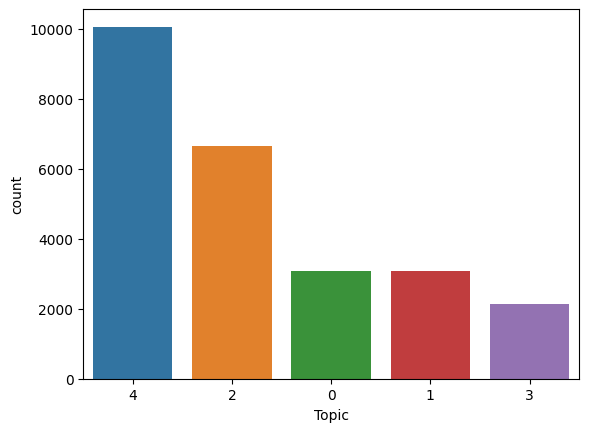

In [161]:
sns.countplot(x = 'Topic',
              data = legal_docs,
              order = legal_docs['Topic'].value_counts().index)

legal_docs['Topic'].value_counts().sort_values(ascending=False)

In [162]:
def sample_titles_per_topic(papers_df, topic_num, sample_count = 5):
  indices = papers_df['Topic'][papers_df['Topic'] == topic_num].index
  
  for i in indices[:sample_count]:
    pprint (papers_df.iloc[i]["case_text"])

In [163]:
print ("Topic 0: ")
sample_titles_per_topic(legal_docs, 0, 1)
print ("-"*100)
print ("Topic 1: ")
sample_titles_per_topic(legal_docs, 1, 1)
print ("-"*100)
print ("Topic 2: ")
sample_titles_per_topic(legal_docs, 2, 1)
print ("-"*100)

Topic 0: 
('Ordinarily that discretion will be exercised so that costs follow the event '
 'and are awarded on a party and party basis. A departure from normal practice '
 'to award indemnity costs requires some special or unusual feature in the '
 'case: Alpine Hardwood (Aust) Pty Ltd v Hardys Pty Ltd (No 2) [2002] FCA 224 '
 '; (2002) 190 ALR 121 at [11] (Weinberg J) citing Colgate Palmolive Co v '
 'Cussons Pty Ltd (1993) 46 FCR 225 at 233 (Sheppard J).')
----------------------------------------------------------------------------------------------------
Topic 1: 
('Numerous cases have held that s 911A of the Act extends to a company '
 "director who conducts or is involved in a company's carrying on of a "
 'financial services business without an Australian financial services '
 'licence: see Australian Securities and Investments Commission v Giann &amp; '
 'Giann Pty Ltd [2005] FCA 81 ; (2005) 141 FCR 278; Australian Securities and '
 'Investments Commission v Manito Pty Ltd (2005

Vectorized Search

In [164]:
def find_matching_docs(tfidf_vectorizer, tfidf_matrix, search_terms, result_count):
  search_vector = tfidf_vectorizer.transform(search_terms)
  cosine_similarities = cosine_similarity(search_vector, tfidf_matrix)

  document_indices = np.argsort(cosine_similarities[0])[::-1]

  # Retrieve and rank documents based on similarity
  ranked_documents = pd.DataFrame([legal_docs.iloc[i] for i in document_indices])[:result_count]

  return ranked_documents


In [166]:
search_terms = ["Native tribes land dispute"]
ranked_docs = find_matching_docs(tfidf, dtm, search_terms, 5)
pprint (ranked_docs.iloc[0]["case_text"])

('The Land Council asserts an absence of native title. The members of the Land '
 'Council are adult Aboriginal persons who are listed on the Local Aboriginal '
 'Land Council membership roll for the area in which the Land is located (s 53 '
 "of the Aboriginal Land Rights Act 1983 (NSW) ('the Land Rights Act')). Once "
 'a determination of no native title is made, that will be conclusive with '
 'respect to the Land. If the non-claimant application for a determination '
 'that native title does not exist over the Land succeeds, that will operate '
 'as a decision in rem and will, subject to the possibility of variation or '
 'revocation under s 13 of the Act, extinguish all and any native title rights '
 'and interests ( Western Australia v Ward [2000] FCA 191 ; (2000) 99 FCR 316 '
 'at [190] ). 33 During the course of the various proceedings Worimi has, as '
 'described in Hillig (No 2) , changed the description of the claim group and '
 'the basis of his own participation, from bein

In [168]:
def summarize_text(text, num_sentences=5, english_level=9):
  response = openai.ChatCompletion.create(
    model = "gpt-3.5-turbo",
    temperature = 0,
    messages = [{"role":"system", "content": f"Follow these instructions when writing the summary:\
      \n1. Write a clear and concise summary consisting of {num_sentences} bullets \
      \n2. Make sure the summary's english level matches that of a person with {english_level} years of education"},
      {"role": "user", "content":f"Write a summary of the following text:{text}"}]
    )

  return response['choices'][0]['message']['content']


In [169]:
doc1_text = ranked_docs.iloc[0]["case_text"]
len(doc1_text)

6946

In [170]:
summary_1 = summarize_text(ranked_docs.iloc[0]["case_text"], num_sentences=5, english_level=7)

In [171]:
pprint (summary_1)

('- The Land Council asserts that there is no native title over the Land\n'
 '- Worimi, who has changed his claim multiple times, has not provided '
 "evidence to support the existence of a women's site on the Land\n"
 "- Worimi's claim of association with the Worimi nation, Garuahgal clan, and "
 'descendents of Mary Mahr is not supported by any other spokesman for any '
 'other family\n'
 '- Worimi acknowledges that the Worimi community is unaware of native title '
 'rights or traditional laws and customs associated with the Land\n'
 '- The Land Council has the right to have its application heard and has '
 'opposed the adjournments sought by Worimi')


In [146]:
search_terms = ["Government", "Banks", "Bankruptcy"]
ranked_docs_2 = find_matching_docs(tfidf, dtm, search_terms, 5)

pprint (ranked_docs_2.iloc[3]["case_text"])

('applicant referred to Lange v Australian Broadcasting Corporation [1997] HCA '
 '25 ; (1997) 189 CLR 520 at 567, 568, where the High Court set out a '
 'two-stage test for determining whether a law infringes the constitutional '
 'implication. The test, as slightly modified in Coleman v Power , is as '
 'follows: (1) Does the law effectively burden freedom of communication about '
 'government or political matters either in its terms, operation or effect? '
 '(2) If so, is the law reasonably appropriate and adapted to serve a '
 'legitimate end in a manner which is compatible with the system of government '
 'prescribed by the Constitution ? The Court in Lange emphasised that the '
 'freedom of communication only covers those communications necessary for the '
 'functioning of the institutions of representative and responsible government '
 'identified in the text and structure of the Constitution (at 561). More '
 'particularly, to the extent that the freedom of communication is an 

In [147]:
len(ranked_docs_2.iloc[3]["case_text"])

7658

In [148]:
summary_2 = summarize_text(ranked_docs_2.iloc[3]["case_text"], num_sentences=5, english_level=3)


In [149]:
pprint (summary_2)


('- The High Court set out a two-stage test for determining if a law infringes '
 'the constitutional implication in Lange v Australian Broadcasting '
 'Corporation.\n'
 '- The test, as modified in Coleman v Power, involves determining if the law '
 'burdens freedom of communication about government or political matters and '
 'if it is reasonably appropriate and adapted to serve a legitimate end.\n'
 '- The freedom of communication only covers necessary communications for the '
 'functioning of representative and responsible government institutions.\n'
 '- The applicant argues that Join the Caravan and Defence of the Muslim Lands '
 "are relevant to voters' choices and opinions on the government's response to "
 'terrorism.\n'
 '- The Attorney argues that the present Code does not burden the freedom of '
 "communication about government or political matters and that Parliament's "
 'choice was reasonable in light of the burden it places on the implied '
 'freedom of communication.')
